#### 0. Code we used to download dataset.

No need to run this since, models are already saved :)

In [ ]:
# 'Amazon_Instant_Video', 
# 'Apps_for_Android', 
# 'Automotive', 
# 'Baby', 
# 'Beauty', 
# 'Digital_Music', 
# 'Grocery_and_Gourmet_Food', 
# 'Health_and_Personal_Care', 
# 'Home_and_Kitchen', 
# 'Kindle_Store'

#DOWLOAD DATASETS

## UNCOMMENT to test :)
#!python Download_files.py -f amvi apps auto baby beau dgmu food heal hmkt kind  -dt r

### 1. Import all packages

In [132]:
from gensim.test.utils import common_texts,datapath
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel
from gensim import corpora 
from gensim.matutils import Sparse2Corpus, Scipy2Corpus
import pandas as pd
import numpy as np
import gzip
import re
import string
import os
from tqdm import tqdm_notebook
from time import time
from hunspell import HunSpell # Installing this caused a lot of hassle
from multiprocessing import pool
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
from gensim.parsing.porter import PorterStemmer
import pickle
import nltk
from joblib import Parallel, delayed
from gensim.corpora import MmCorpus
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import chain
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


nltk.download('stopwords')

spellchecker = HunSpell('dicts_hun/en_US.dic',
                        'dicts_hun/en_US.aff')

stemmer = PorterStemmer()

names = ['Amazon_Instant_Video', 
         'Apps_for_Android', 
         'Automotive', 
         'Baby', 
         'Beauty', 
         'Digital_Music', 
         'Grocery_and_Gourmet_Food', 
         'Health_and_Personal_Care', 
         'Home_and_Kitchen', 
         'Kindle_Store'
        ]

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Word preprocessing! It doesn't take a lot of time, if files in `results` folder exists, preprocessing won't be run again and files will be loaded!

1. Datasets are loaded (this is **SLOW**, but parallized! You can set number of cores with `paralelize_reading`. TAKES A LOT OF **RAM**)
2. `n` comments are randomly chosen
3. Remove punctionation and digits
4. Remove STOP words 'he', 'she', 'is' etc.
5. Remove wrongly spelled words (we thought of spelling them correctly, but it slows process 50x times!)
6. Stemming! `stemmer.stem('ponies') -> 'poni`
7. Remove rare words
8. Create dictionary, vocabulary, corpus and SAVE THEM!

In [43]:
force_rerun_preprocessing = 0 ## If you want run code again even if files exist
paralelize_reading = 12 ## Number of cores used for reading, set to 1 if you don't want to paralelize

def read_dataset(name):
    df = getDF('data/reviews/reviews_{}.json.gz'.format(name))
    print('Reading {} finished!'.format(name))
    return df.reviewText + ' ' + df.summary + ' '
    

if ((os.path.isfile('results/corpus.pickle') and 
    os.path.isfile('results/dictionary.pickle') and
    os.path.isfile('results/vocab.pickle')) and not(force_rerun_preprocessing)):
    
    with open('results/corpus.pickle', 'rb') as f:
        corpus = pickle.load(f)
    with open('results/dictionary.pickle', 'rb') as f:
        dictionary = pickle.load(f)
    with open('results/vocab.pickle', 'rb') as f:
        vocabulary = pickle.load(f)
        
    print('Files already exist! No need to load this again!')
else:

    ans = ''

#     for name in tqdm_notebook(names):

#         df = getDF('data/reviews/reviews_{}.json.gz'.format(name))
#         ans += df.reviewText + ' ' + df.summary + ' '

    ## Let's use those cores :p
    print('Reading datasets')
    array_ans = Parallel(n_jobs=paralelize_reading)(delayed(read_dataset)(name) for name in names)
    
    for temp in array_ans:
        ans+=temp

    n = 50000

    re_punctuation = re.compile('['+string.punctuation+']')
    tokenizer = RegexpTokenizer('\w+')
    stop = stopwords.words('english')
    preprocessed_comments = []
    for comment in tqdm_notebook(np.random.choice(ans, n)):
        comment = re_punctuation.sub(' ', comment)
        comment = tokenizer.tokenize(comment)
        comment = [x for x in comment if not any(c.isdigit() for c in x)]
        comment = [word for word in comment if word not in stop]
        comment = [stemmer.stem(x) for x in comment if spellchecker.spell(x)]
        comment = [x for x in comment if len(x) > 3]
        preprocessed_comments.append(comment)
    
    
    wordFrequency = Counter()
    for comment in tqdm_notebook(preprocessed_comments):
        wordFrequency.update(comment)                                  # Count overall word frequency
    print('Unique Words In Comments: {}'.format(len(wordFrequency)))

    minimumWordOccurrences = 5
    # Remove rare words
    print('Removing rare words... ')
    texts = [[word for word in comment if wordFrequency[word] > minimumWordOccurrences] for comment in tqdm_notebook(preprocessed_comments)]

    print('Creating vocabulary...')
    dictionary = corpora.Dictionary(texts)                             # Create word dictionary
    vocabulary = [dictionary[i] for i in tqdm_notebook(dictionary.keys())]
    print('Documents/Comments: {}'.format(len(texts)))

    print('Creating corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in tqdm_notebook(preprocessed_comments)] # Create corpus

    
    print('Saving files...')
    with open('results/corpus.pickle', 'wb') as f:
        pickle.dump(corpus, f)
    with open('results/dictionary.pickle', 'wb') as f:
        pickle.dump(dictionary, f)
    with open('results/vocab.pickle', 'wb') as f:
        pickle.dump(vocabulary, f)
    
    print('WE ARE GOOD TO GO!')

Unique Words In Comments: 29177
Removing rare words... 


Creating vocabulary...


Documents/Comments: 50000
Creating corpus...


Saving files...
WE ARE GOOD TO GO!


#### Training is computationaly heavy and can take up to 5 hours, this has been processed on AWS EC2 cluster.
Note: If models exist in `results` folder, training won't run again and already existing model will be loaded.
You can freely run this cell.

In [134]:
force_rerun_lda = 0

if (os.path.isfile('results/model_genism/model_genism.model') & (not force_rerun_lda)):
    model_genism = LdaMulticore.load("results/model_genism/model_genism.model", mmap='r')
    with open('results/model_genism/perp_gensim.pickle', 'rb') as f:
        perp_gensim = pickle.load(f)
    with open('results/model_genism/time_gensim.pickle', 'rb') as f:
        time_gensim = pickle.load(f)
else:
    numberTopics = 500  #Number of topics
    model_gensim = LdaMulticore(num_topics=numberTopics,
                            id2word=dictionary,
                            iterations=10,
                            passes=1,
                            chunksize=50,
                            eta='auto',
                            workers=12)

    
    
    

    oned_corpus = np.array(list(chain.from_iterable(corpus)))
    ones_data = np.ones(shape=(oned_corpus.shape[0],), dtype=np.float64)
    corpus_sparse = coo_matrix((ones_data, (oned_corpus[:,0], oned_corpus[:,1])))
    tfidf_transformer = TfidfTransformer()
    corpus_tfidf = tfidf_transformer.fit_transform(corpus_sparse)
    genism_corpus_final = Sparse2Corpus(corpus_tfidf)

    

    
    
    
    perp_gensim = []
    times_gensim = []
    i=0
    max_it = 5
    min_prep = np.inf
    start = time()
    for _ in tqdm_notebook(range(100)):
        model_gensim.update(genism_corpus_final)
        tmp = np.exp(-1 * model_gensim.log_perplexity(genism_corpus_final))
        perp_gensim.append(tmp)
        times_gensim.append(time() - start)
        if(tmp<min_prep):
            min_prep = tmp;
            i = 0
        else:
            i = i + 1;
            if (i==max_it):
                break                # if prep increase for max_it number it will break the update procedure 
    model_gensim.save('results/model_genism/model_genism.model')
    with open('results/model_genism/perp_gensim.pickle', 'wb') as f:
        pickle.dump(perp_gensim, f)
    with open('results/model_genism/time_gensim.pickle', 'wb') as f:
        pickle.dump(times_gensim, f)
    
for i, topic in enumerate(model_gensim.get_topics().argsort(axis=1)[:, -10:][:, ::-1], 1):
    print('Topic {}: {}'.format(i, ' '.join([vocabulary[id] for id in topic])))

Topic 1: love murdoch sprocket jurisprud feta arron eunuch phrasebook dogfish vlad
Topic 2: sardin hair gate album time coffe stroller waffl filter realli
Topic 3: sardin realli juicer coffe potti work stroller gate waffl book
Topic 4: tyrosin work dingl would product rosario good yule chican chrysanthemum
Topic 5: stroller album coffe hair gate monitor waffl would time ruben
Topic 6: coffe would well hair waffl potti product time book elton
Topic 7: hair waffl coffe time song gate sardin album make stroller
Topic 8: realli time album coffe hair well would make product gate
Topic 9: banyan hammerhead navajo triag judder midshipman genoa mitford faro olli
Topic 10: coffe album potti waffl gate hair juicer popcorn sardin stroller
Topic 11: karyn thea burnsid cortez monsanto genoa leland mitford salom liza
Topic 12: scott helga brianna cathryn tibet acetaminophen illuminati burma mackenzi dariu
Topic 13: frier heliocentr esoterica lumen xian cervant clio pepsin lynett carillon
Topic 14: p

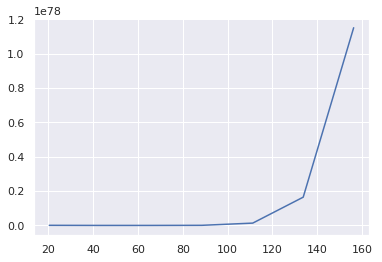

In [135]:
plt.plot(times_gensim, perp_gensim)